/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible
re._pattern:  STAEformer_subway_in_(?:subway_out|calendar).*?bis
trials found:  14
   STAEformer_subway_in_subway_out_calendar_early_fusion_early_fusion_shared_embedding__e100_h1
   STAEformer_subway_in_subway_out_calendar_early_fusion_early_fusion_independant_embedding__e100_h4
   STAEformer_subway_in_subway_out_calendar_early_fusion_early_fusion_s_proj_t_proj__e100_h1
   STAEformer_subway_in_subway_out_calendar_late_fusion_late_fusion_BackBone_InEmb24_adp16__e100_h4
   STAEformer_subway_in_calendar__e100_h1
   STAEformer_subway_in_subway_out_calendar_early_fusion_early_fusion_BackBone_InEmb24_adp16__e100_h1
   STAEformer_subway_in_subway_out_calendar_early_fusion_early_fusion_shared_embedding__e100_h4
   STAEformer_subway_in_subway_out_calendar_early_fusion_early_fusion_BackBone_InEmb24_adp16__e100_h4
   STAEformer_subway_in_subway_out_calendar_l

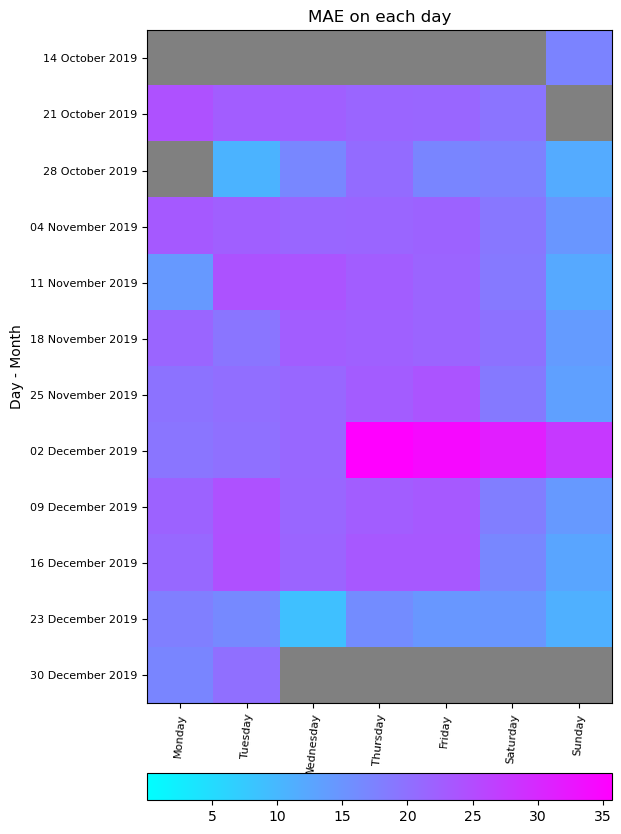

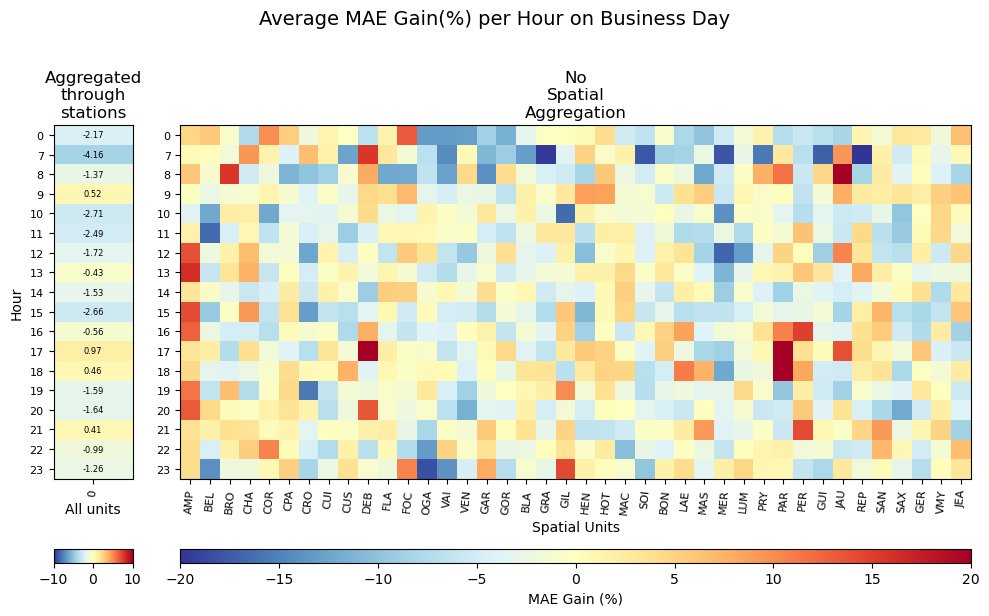

full_predict1.size(): torch.Size([4989, 40, 1, 1])
full_predict2.size(): torch.Size([4989, 40, 1, 1])


In [1]:
import os 
import pandas as pd 
import sys 
import re 
import torch 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path,'..','..','..','..'))  # '..','..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from pipeline.utils.utilities import load_saved_trials
from pipeline.Evaluation.STDA2.accuracy_comparison import get_model_args,get_desagregated_comparison_plot
from experiences.common_results import find_baseline
from experiences.common_parameter import convertion_exp_name

# ------------------------------------------
exp_i = 'pipeline_subway_in'
freq = '15min' #'15min'  
horizons = [1,4] # [4]  #[1,4]
model_name = 'STAEformer'
target_data = 'subway_in' 
dataset_for_coverage = ['subway_in','subway_out'] #['subway_in','subway_out','netmob_POIs']
contextual_dataset_names = ['subway_out'] # ['netmob_POIs'] #['subway_out']
TRIVIAL_TEST = False
REPEAT_TRIAL = 1 #5 # 10
# ------------------------------------------


# Load trials:
trials = load_saved_trials(exp_i, model_name, target_data, contextual_dataset_names)

# Load full_predict1 and full_predict2: 
for h in horizons:
    exp_tmp = convertion_exp_name(target_data,contextual_dataset_names)
    baseline = find_baseline(exp_i,h=h,exp_tmp=exp_tmp,configs=trials)
    trial_ids2 = [f"{config}_bis" for config in trials if (config.endswith(f"_h{h}")) and not(baseline == config)]
    trial_ids1 = [f"{baseline}_bis"]*len(trial_ids2)
    save_folder_name = f'{exp_i}/{target_data}_{model_name}'
    save_folder_name_bis = None

    model_args,model_args_bis,path_model_args,path_model_args_bis = get_model_args(save_folder_name,save_folder_name_bis)


    for trial_id1,trial_id2 in zip(trial_ids1,trial_ids2):
        outputs = get_desagregated_comparison_plot(
                    trial_id1,
                    trial_id2,
                    model_args = model_args,
                    model_args_bis = model_args_bis,
                    path_model_args = path_model_args,
                    path_model_args_bis = path_model_args_bis,
                    range_k = range(1,REPEAT_TRIAL+1),
                )
        clusterer,full_predict1,full_predict2,train_input,X,Y_true,L_trainers_1,L_trainers_2,ds1,ds2,args_init1,args_init2, dic_bd_metrics = outputs
        break
    break
        
print("full_predict1.size():",full_predict1.size())
print("full_predict2.size():",full_predict2.size())



28104   2019-10-20 18:00:00
28105   2019-10-20 18:15:00
28106   2019-10-20 18:30:00
28107   2019-10-20 18:45:00
28108   2019-10-20 19:00:00
                ...        
35034   2019-12-31 22:30:00
35035   2019-12-31 22:45:00
35036   2019-12-31 23:00:00
35037   2019-12-31 23:15:00
35038   2019-12-31 23:30:00
Name: t+0, Length: 4989, dtype: datetime64[ns]

In [8]:
from experiences.pipeline_desag.ML_desag_analysis.EventGainDatasetBuilder import EventGainDatasetBuilder
import numpy as np

dates = ds2.tensor_limits_keeper.df_verif_test.iloc[:,-1] #ds2.df_dates['date']
B,N = full_predict1.size(0), full_predict1.size(1)
spatial_features_df = pd.DataFrame({
    'station_id': ds2.spatial_unit,
    'is_transport_hub': np.random.choice([0, 1], N),
    'is_activity_zone': np.random.choice([0, 1], N),
    'is_commercial_zone': np.random.choice([0, 1], N)
})

weather_df = pd.DataFrame({
    'datetime': dates,
    'rainfall_intensity': np.random.uniform(0, 15, B)
}).set_index('datetime')

calendar_df = pd.DataFrame({
    'datetime': dates,
    'is_school_holiday': np.random.choice([0, 1], B)
}).set_index('datetime')


# Instanciation de la classe
builder = EventGainDatasetBuilder(
    full_predict1=full_predict1,
    full_predict2=full_predict2,
    Y_true=Y_true,
    ds=ds2,
    dates=dates,
    spatial_features_df=spatial_features_df,
    weather_df=weather_df,
    calendar_df=calendar_df
)

# Extraction du dataset
events_df = builder.get_dataset(metric='mae', target_horizon_idx=0, min_flow=20)

# Vérification des résultats
print(f"Dimension du dataset final : {events_df.shape}")
print(events_df.head())

Dimension du dataset final : (176194, 14)
             datetime station_id  demand  error_mod1  error_mod2       gain  \
0 2019-10-20 18:00:00        AMP    23.0   12.918179   12.121361   6.168190   
1 2019-10-20 18:00:00        BEL   412.0   95.063721   51.070770  46.277328   
2 2019-10-20 18:00:00        BRO    39.0    5.769505    5.086979  11.829883   
3 2019-10-20 18:00:00        CHA   209.0   21.171814   30.294601 -43.089306   
4 2019-10-20 18:00:00        COR    99.0    8.399826    1.672020  80.094589   

   weekday  hour  minute  rainfall_intensity  is_school_holiday  \
0        6    18       0           14.827587                  0   
1        6    18       0           14.827587                  0   
2        6    18       0           14.827587                  0   
3        6    18       0           14.827587                  0   
4        6    18       0           14.827587                  0   

   is_transport_hub  is_activity_zone  is_commercial_zone  
0                 0 